In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
def analyze_bjt_sr_flip_flop(frequencies, R_base, C_bc, C_be):
    t_delay = 35e-9       # Delay time (s)
    t_rise = 35e-9        # Rise time (s)
    t_storage = 200e-9    # Storage time (s)
    t_fall = 50e-9        # Fall time (s)

    rise_times = []
    fall_times = []
    noise_levels = []
    snrs = []
    max_reliable_freqs = []

    for f in frequencies:
        base_rise_time = t_delay + t_rise
        base_fall_time = t_storage + t_fall
        rc_time = R_base * (C_bc + C_be)

        freq_factor = 1 + 0.5 * f / 1e6
        rise_time = base_rise_time * freq_factor
        fall_time = base_fall_time * freq_factor

        noise = 0.01 + 0.02 / np.sqrt(f)  # Example 1/f noise model
        signal_amplitude = 5.0
        snr = signal_amplitude / noise
        max_reliable_freq = 1 / (rise_time + fall_time)

        rise_times.append(rise_time)
        fall_times.append(fall_time)
        noise_levels.append(noise)
        snrs.append(snr)
        max_reliable_freqs.append(max_reliable_freq)

    return (np.array(rise_times), np.array(fall_times),
            np.array(noise_levels), np.array(snrs),
            np.array(max_reliable_freqs))


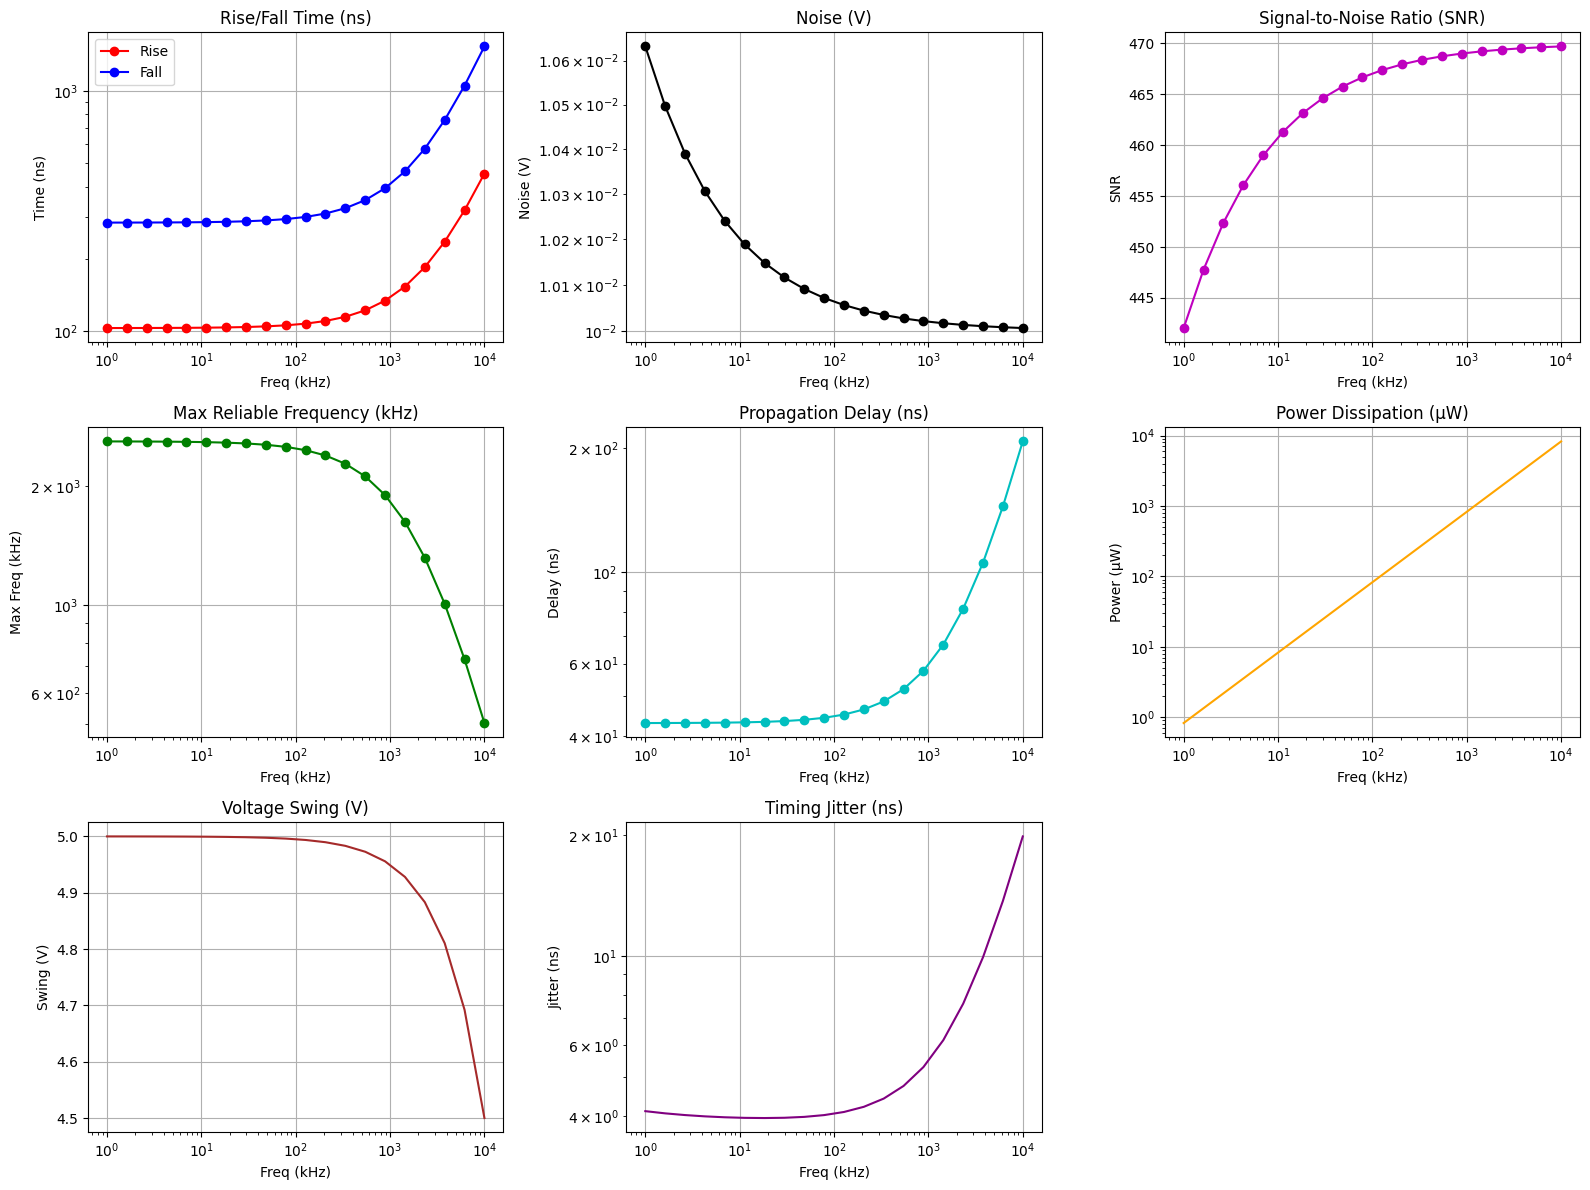


=== Summary ===
Max Power Dissipation: 8250.00 μW
Max Propagation Delay: 208.00 ns
Max Jitter: 19.87 ns
Minimum Voltage Swing: 4.50 V


In [16]:
# 📌 STEP 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt

# 📌 STEP 2: Define simulation function
def analyze_sr_flip_flop_with_freq_effects(frequencies, R_base, C_bc, C_be, Vcc=5.0):
    # Basic switching characteristics of 2N2222
    t_delay = 35e-9
    t_rise = 35e-9
    t_storage = 200e-9
    t_fall = 50e-9

    # Arrays to store results
    rise_times, fall_times, noise_levels = [], [], []
    snrs, max_freqs, power_dissipations = [], [], []
    propagation_delays, voltage_swings, jitters = [], [], []

    for f in frequencies:
        # RC delay
        rc_time = R_base * (C_bc + C_be)

        # Adjusted switching times
        freq_factor = 1 + 0.5 * f / 1e6  # increases with frequency
        rise_time = (t_delay + t_rise) * freq_factor + rc_time
        fall_time = (t_storage + t_fall) * freq_factor + rc_time

        # Noise (thermal + frequency-dependent)
        thermal_noise = 0.01
        freq_noise = 0.02 / np.sqrt(f)
        total_noise = thermal_noise + freq_noise

        # SNR
        signal_amplitude = Vcc - 0.3
        snr = signal_amplitude / total_noise

        # Max frequency before flip-flop fails
        max_freq = 1 / (rise_time + fall_time)

        # Propagation delay increases with frequency
        prop_delay = 10e-9 + rc_time * freq_factor

        # Power dissipation (dynamic)
        dynamic_power = f * (C_bc + C_be) * (Vcc ** 2)

        # Voltage swing degrades with frequency
        voltage_swing = Vcc - (f / 1e7) * 0.5

        # Jitter increases with noise and switching time
        jitter = total_noise * (rise_time + fall_time)

        # Append results
        rise_times.append(rise_time)
        fall_times.append(fall_time)
        noise_levels.append(total_noise)
        snrs.append(snr)
        max_freqs.append(max_freq)
        propagation_delays.append(prop_delay)
        power_dissipations.append(dynamic_power)
        voltage_swings.append(voltage_swing)
        jitters.append(jitter)

    return {
        "frequencies": frequencies,
        "rise_times": np.array(rise_times),
        "fall_times": np.array(fall_times),
        "noise_levels": np.array(noise_levels),
        "snrs": np.array(snrs),
        "max_freqs": np.array(max_freqs),
        "propagation_delays": np.array(propagation_delays),
        "power_dissipations": np.array(power_dissipations),
        "voltage_swings": np.array(voltage_swings),
        "jitters": np.array(jitters)
    }

# 📌 STEP 3: Run the simulation
frequencies = np.logspace(3, 7, 20)  # 1 kHz to 10 MHz
R_base = 1e3                         # 1kΩ
C_bc = 8e-12                         # 8pF
C_be = 25e-12                        # 25pF

results = analyze_sr_flip_flop_with_freq_effects(frequencies, R_base, C_bc, C_be)

# 📌 STEP 4: Plot results
f_kHz = results['frequencies'] / 1e3

plt.figure(figsize=(16, 12))

# Rise/Fall Time
plt.subplot(3, 3, 1)
plt.loglog(f_kHz, results['rise_times']*1e9, 'r-o', label='Rise')
plt.loglog(f_kHz, results['fall_times']*1e9, 'b-o', label='Fall')
plt.title('Rise/Fall Time (ns)')
plt.xlabel('Freq (kHz)')
plt.ylabel('Time (ns)')
plt.grid(True)
plt.legend()

# Noise
plt.subplot(3, 3, 2)
plt.loglog(f_kHz, results['noise_levels'], 'k-o')
plt.title('Noise (V)')
plt.xlabel('Freq (kHz)')
plt.ylabel('Noise (V)')
plt.grid(True)

# SNR
plt.subplot(3, 3, 3)
plt.semilogx(f_kHz, results['snrs'], 'm-o')
plt.title('Signal-to-Noise Ratio (SNR)')
plt.xlabel('Freq (kHz)')
plt.ylabel('SNR')
plt.grid(True)

# Max Frequency
plt.subplot(3, 3, 4)
plt.loglog(f_kHz, results['max_freqs']/1e3, 'g-o')
plt.title('Max Reliable Frequency (kHz)')
plt.xlabel('Freq (kHz)')
plt.ylabel('Max Freq (kHz)')
plt.grid(True)

# Propagation Delay
plt.subplot(3, 3, 5)
plt.loglog(f_kHz, results['propagation_delays']*1e9, 'c-o')
plt.title('Propagation Delay (ns)')
plt.xlabel('Freq (kHz)')
plt.ylabel('Delay (ns)')
plt.grid(True)

# Power Dissipation
plt.subplot(3, 3, 6)
plt.loglog(f_kHz, results['power_dissipations']*1e6, 'orange', label='μW')
plt.title('Power Dissipation (μW)')
plt.xlabel('Freq (kHz)')
plt.ylabel('Power (μW)')
plt.grid(True)

# Voltage Swing
plt.subplot(3, 3, 7)
plt.semilogx(f_kHz, results['voltage_swings'], 'brown')
plt.title('Voltage Swing (V)')
plt.xlabel('Freq (kHz)')
plt.ylabel('Swing (V)')
plt.grid(True)

# Jitter
plt.subplot(3, 3, 8)
plt.loglog(f_kHz, results['jitters']*1e9, 'purple')
plt.title('Timing Jitter (ns)')
plt.xlabel('Freq (kHz)')
plt.ylabel('Jitter (ns)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 📌 STEP 5: Summary Stats
print("\n=== Summary ===")
print(f"Max Power Dissipation: {np.max(results['power_dissipations']) * 1e6:.2f} μW")
print(f"Max Propagation Delay: {np.max(results['propagation_delays']) * 1e9:.2f} ns")
print(f"Max Jitter: {np.max(results['jitters']) * 1e9:.2f} ns")
print(f"Minimum Voltage Swing: {np.min(results['voltage_swings']):.2f} V")


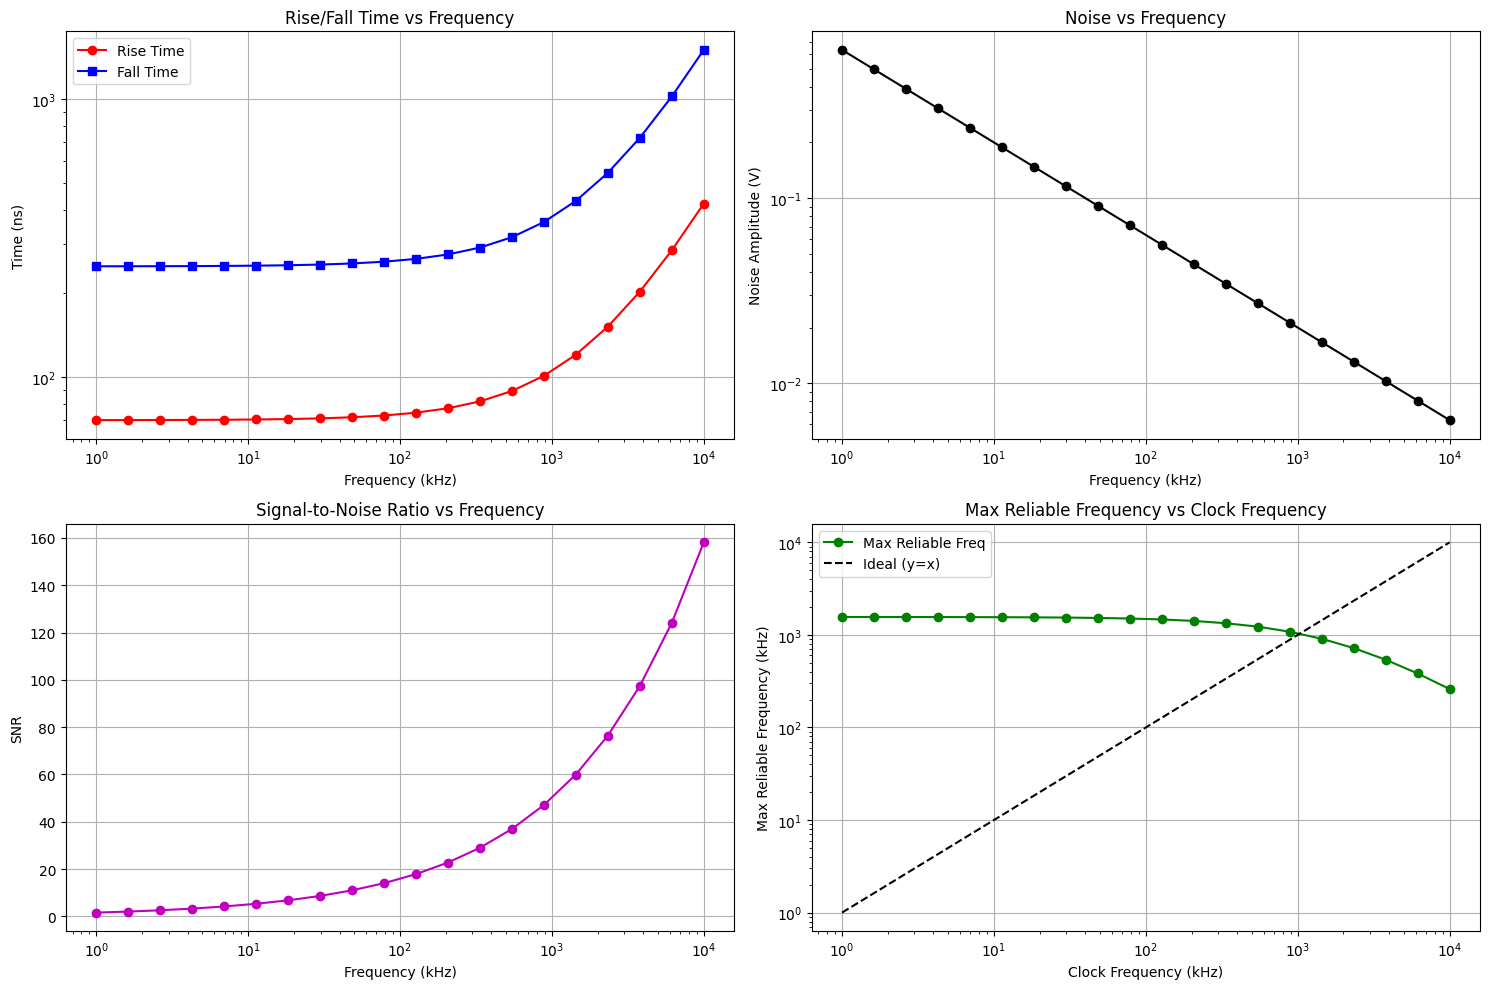

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square

# 2N2222 transistor parameters (typical from datasheet)
t_delay = 35e-9       # Delay time (s)
t_rise = 35e-9        # Rise time (s)
t_storage = 200e-9    # Storage time (s)
t_fall = 50e-9        # Fall time (s)
C_bc = 8e-12          # Collector-base capacitance (F)
C_be = 25e-12         # Base-emitter capacitance (F)

# Resistor value
R_base = 1e3  # Ohms

# Frequency range to simulate
frequencies = np.logspace(3, 7, 20)  # 1 kHz to 10 MHz

# Arrays to store results
rise_times = []
fall_times = []
noise_levels = []
max_reliable_freqs = []
snrs = []

# Frequency sweep analysis
for freq in frequencies:
    rc_time = R_base * (C_bc + C_be)
    freq_factor = 1 + 0.5 * freq / 1e6  # linear model for capacitance charge lag

    rise = (t_delay + t_rise) * freq_factor
    fall = (t_storage + t_fall) * freq_factor
    noise = 0.02 * np.sqrt(1e6 / freq)
    min_clk_period = 2 * (rise + fall)
    max_reliable = 1 / min_clk_period
    snr = 1 / noise

    rise_times.append(rise)
    fall_times.append(fall)
    noise_levels.append(noise)
    max_reliable_freqs.append(max_reliable)
    snrs.append(snr)

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.loglog(frequencies / 1e3, np.array(rise_times) * 1e9, 'r-o', label="Rise Time")
plt.loglog(frequencies / 1e3, np.array(fall_times) * 1e9, 'b-s', label="Fall Time")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Time (ns)")
plt.title("Rise/Fall Time vs Frequency")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.loglog(frequencies / 1e3, noise_levels, 'k-o')
plt.xlabel("Frequency (kHz)")
plt.ylabel("Noise Amplitude (V)")
plt.title("Noise vs Frequency")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.semilogx(frequencies / 1e3, snrs, 'm-o')
plt.xlabel("Frequency (kHz)")
plt.ylabel("SNR")
plt.title("Signal-to-Noise Ratio vs Frequency")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.loglog(frequencies / 1e3, np.array(max_reliable_freqs) / 1e3, 'g-o', label="Max Reliable Freq")
plt.loglog(frequencies / 1e3, frequencies / 1e3, 'k--', label="Ideal (y=x)")
plt.xlabel("Clock Frequency (kHz)")
plt.ylabel("Max Reliable Frequency (kHz)")
plt.title("Max Reliable Frequency vs Clock Frequency")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


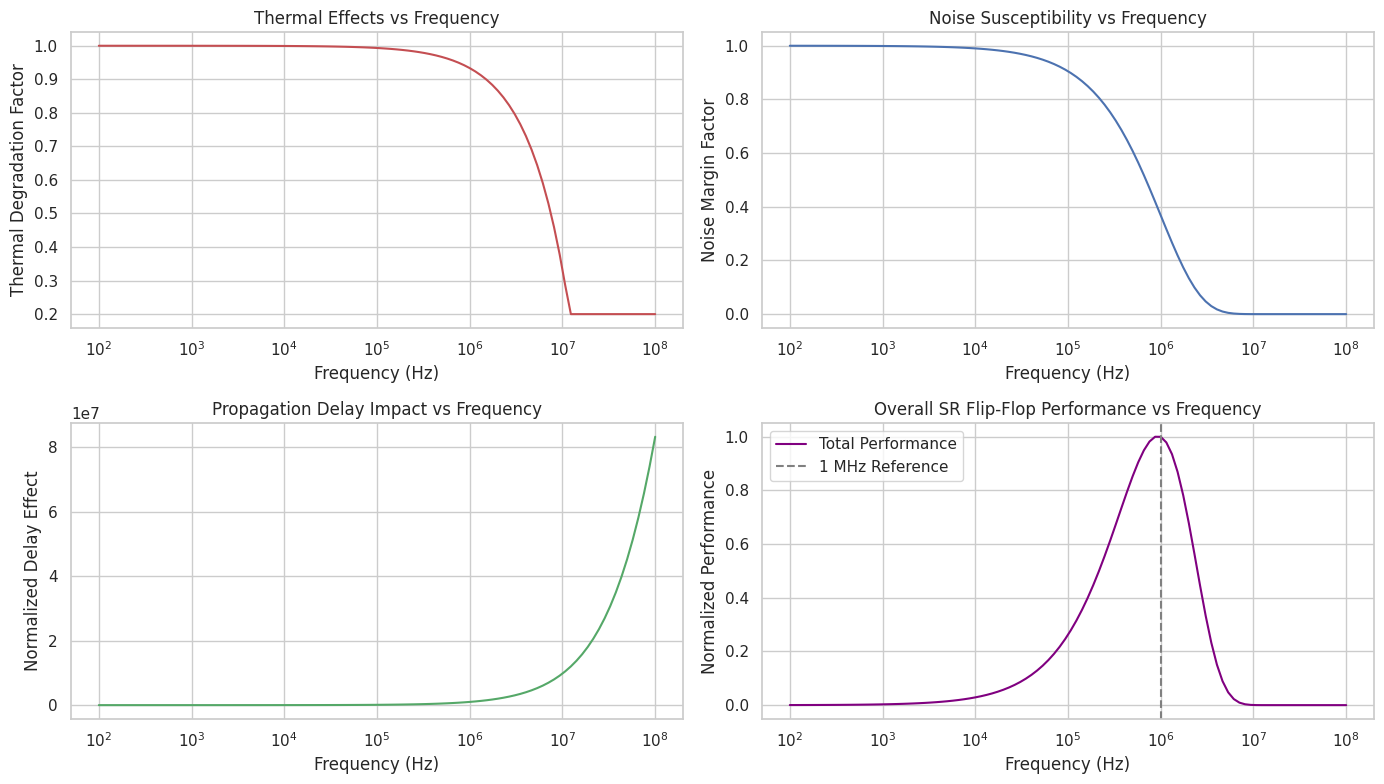

In [18]:
# BJT SR Flip-Flop Performance Analysis with 2N2222
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Constants for 2N2222 typical values
V_BE = 0.7  # base-emitter voltage (V)
V_CEsat = 0.2  # collector-emitter saturation voltage (V)
hFE_typ = 100  # typical DC current gain
fT = 250e6  # transition frequency in Hz
P_max = 500e-3  # max power dissipation (W)

# Simulation Parameters
frequencies = np.logspace(2, 8, 100)  # 100 Hz to 100 MHz

# Model thermal effect (simplified)
def thermal_degradation(f, T_ambient):
    # Assume transistor heats up linearly with frequency
    delta_T = 0.00001 * f  # degrees per Hz (arbitrary scale)
    T_junction = T_ambient + delta_T
    return np.clip(1 - (T_junction - 25) / 150, 0.2, 1.0)  # limit degradation factor

# Power dissipation model
V_CC = 5  # supply voltage
Ic = 10e-3  # collector current (10 mA)
Pd = V_CEsat * Ic

# Environmental Noise Effect (arbitrary exponential decay)
def noise_margin_loss(f):
    return np.exp(-f / 1e6)

# Propagation delay model (simplified)
def propagation_delay(f):
    return 1 / (2 * fT) + 1 / f

# Normalized performance metric
performance = []
thermal_perf = thermal_degradation(frequencies, 25)
noise_effect = noise_margin_loss(frequencies)
delay_effect = 1 / propagation_delay(frequencies)

for t, n, d in zip(thermal_perf, noise_effect, delay_effect):
    perf = t * n * d
    performance.append(perf)

performance = np.array(performance)

# Plotting
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(frequencies, thermal_perf, label="Thermal Effect", color="r")
plt.xscale('log')
plt.ylabel("Thermal Degradation Factor")
plt.xlabel("Frequency (Hz)")
plt.title("Thermal Effects vs Frequency")

plt.subplot(2, 2, 2)
plt.plot(frequencies, noise_effect, label="Noise Margin", color="b")
plt.xscale('log')
plt.ylabel("Noise Margin Factor")
plt.xlabel("Frequency (Hz)")
plt.title("Noise Susceptibility vs Frequency")

plt.subplot(2, 2, 3)
plt.plot(frequencies, delay_effect, label="Delay Impact", color="g")
plt.xscale('log')
plt.ylabel("Normalized Delay Effect")
plt.xlabel("Frequency (Hz)")
plt.title("Propagation Delay Impact vs Frequency")

plt.subplot(2, 2, 4)
plt.plot(frequencies, performance / np.max(performance), label="Total Performance", color="purple")
plt.axvline(1e6, color='gray', linestyle='--', label='1 MHz Reference')
plt.xscale('log')
plt.ylabel("Normalized Performance")
plt.xlabel("Frequency (Hz)")
plt.title("Overall SR Flip-Flop Performance vs Frequency")
plt.legend()

plt.tight_layout()
plt.show()
